In [1]:
import os
import sys

import cv2
from dbfread import DBF
import numpy as np
import pandas
import json
import shapefile
from geopy.distance import distance
import matplotlib.pyplot as plt

### Data: classification

In [2]:
kenya_dbf = DBF("local/kenya/Kenya_Rds/kenya_osm_all_highways_091019.dbf", encoding='iso-8859-1')
kenya_shp = open("local/kenya/Kenya_Rds/kenya_osm_all_highways_091019.shp", "rb")
kenya_sf = shapefile.Reader(shp=kenya_shp)

peru_dbf = DBF("local/peru/Peru_Rds/peru_osm_all_highways_091019.dbf", encoding='iso-8859-1')
peru_shp = open("local/peru/Peru_Rds/peru_osm_all_highways_091019.shp", "rb")
peru_sf = shapefile.Reader(shp=peru_shp)

conversion = {
    "motorway": "major",
    "trunk": "major",
    "primary": "major",
    "secondary": "major",
    "tertiary": "minor",
    "unclassified": "minor",
    "motorway_link": "major",
    "trunk_link": "major",
    "primary_link": "major",
    "secondary_link": "major",
    "tertiary_link": "minor",
    "track": "two-track"
}

def parse_shapefile(sf, dbf, classmap):
    processed = []
    
    for i, (rec, shape) in enumerate(zip(dbf, sf.shapes())):
        if rec["highway"] in classmap:
            processed.append([len(processed), i, rec["osm_id"], rec["name"], rec["highway"], classmap[rec["highway"]]])
        if i % 100000 == 0:
            print("Processed ", i)
    
    df = pandas.DataFrame.from_records(processed)
    df = df.rename({0:"index", 1:"shp", 2:"osm_index", 3:"name", 4:"highway", 5:"class"}, axis=1)
    df = df.set_index("index")
    
    return df

kenya_osm = parse_shapefile(kenya_sf, kenya_dbf, classmap=conversion)
peru_osm = parse_shapefile(peru_sf, peru_dbf, classmap=conversion)

Processed  0
Processed  100000
Processed  200000
Processed  300000
Processed  400000
Processed  0
Processed  100000
Processed  200000
Processed  300000
Processed  400000


### Data : geolocation 

In [3]:
kenya_csv = "./roadtype/kenya_roads_bbox_300m.csv"
peru_csv = "./roadtype/peru_roads_bbox_300m.csv"

kenya_geo = pandas.read_csv(kenya_csv, index_col="index")
kenya_geo = kenya_geo.drop(columns=["Unnamed: 0"])
kenya_geo = kenya_geo.rename(lambda x: x.lower(), axis="columns")
kenya_geo = kenya_geo.reindex(sorted(kenya_geo.columns), axis=1)

peru_geo = pandas.read_csv(peru_csv, index_col="index")
peru_geo["lat"] = list(map(lambda x: json.loads(x)["coordinates"][1], peru_geo[".geo"]))
peru_geo = peru_geo.drop(columns=[".geo", "system:index"])
peru_geo = peru_geo.sort_index()
peru_geo = peru_geo.reindex(sorted(peru_geo.columns), axis=1)

### Test

In [5]:
display(peru_geo[:5]), display(peru_osm[50:55]);

,id,lat,lon,maxlat,maxlon,minlat,minlon
index,,,,,,,
1.0,220646.0,-12.043262,-77.026497,-12.041912,-77.025123,-12.044611,-77.027866
2.0,220646.0,-12.043240,-77.027007,-12.041890,-77.025634,-12.044589,-77.028376
3.0,220647.0,-12.031368,-77.056046,-12.030018,-77.054673,-12.032717,-77.057415
4.0,220647.0,-12.031381,-77.056036,-12.030031,-77.054663,-12.032730,-77.057405
5.0,220650.0,-12.032240,-77.005648,-12.030890,-77.004274,-12.033589,-77.007017


,shp,osm_index,name,highway,class
index,,,,,
50,89,4819353,Recoleta,tertiary,minor
51,90,4819356,Sacsayhuam?¡n,tertiary,minor
52,91,4819358,,tertiary,minor
53,92,4819371,Punete P?­sac,trunk,major
54,93,4819374,,unclassified,minor


In [32]:
geo_id = 135109

In [33]:
index = peru_geo[peru_geo["id"] == geo_id].index.values[0]
peru_geo[peru_geo["id"] == geo_id]

,id,lat,lon,maxlat,maxlon,minlat,minlon
index,,,,,,,
66719.0,135109.0,-12.706041,-73.741323,-12.704691,-73.739947,-12.707390,-73.742696
66720.0,135109.0,-12.714977,-73.745742,-12.713627,-73.744365,-12.716326,-73.747114


In [15]:
shp = peru_osm[peru_osm.index.values == (index + 1) // 2]["shp"].values[0]
peru_osm[peru_osm.index.values == (index + 1) // 2]

,shp,osm_index,name,highway,class
index,,,,,
42019,187843,428244546,Avenida Berrocal,track,two-track


In [14]:
peru_sf.shape(shp).points

[(-77.0154024, -12.0432147),
 (-77.0150162, -12.0430385),
 (-77.0136957, -12.0420487),
 (-77.0131965, -12.0416838),
 (-77.0123645, -12.0410442),
 (-77.0115194, -12.0405072),
 (-77.0110651, -12.0402943),
 (-77.0104904, -12.0400484),
 (-77.0100886, -12.0398522),
 (-77.0094905, -12.0396234),
 (-77.0058585, -12.0380929)]

In [34]:
for road in peru_road_images:
    if str(135109) in road:
        print(road)

peru_1000x1000_135109_55373.tif
peru_1000x1000_64381_135109.tif
peru_1000x1000_64407_135109.tif


### Sample TIFF

In [3]:
peru_road_images = []
with open("local/peru/peru_road_images.txt", "r") as images:
    for image in images:
        peru_road_images.append(image.strip())
        
kenya_road_images = []
with open("local/kenya/kenya_road_images.txt", "r") as images:
    for image in images:
        kenya_road_images.append(image.strip())

In [4]:
def sample(road_images, road_cls, road_geo):
    arr = []
    count = 0
    for i, image in enumerate(road_images):
        if i % 20 == 0:
            idx = float(image.split(.)[0].split('_')[-1])
            if road_cls[road_geo[idx]]['roadtype'] == 'minor':
                cv_obj = cv2.imread(file)
                if not cv_obj is None:
                    row = np.mean(np.array(cv_obj), axis=(0, 1))
                    row = np.append(row, float(kenya_dict[kenya_id_dict[float(file.split('_')[-1].split('.')[0])]]['length']))
                    if row.shape[0] == 4:
                        arr.append(row)
                    count += 1
            #print(np.array(cv2.imread(file)).shape)
        i+=1
        if count > 99:
            break
    k_minor_arr = np.array(arr)
    print(k_minor_arr.shape)
    print(np.mean(k_minor_arr, axis=0))

SyntaxError: invalid syntax (<ipython-input-4-45f50e8b39e3>, line 6)

### Variables of Interest

In [ ]:
def curvature(shape):
    radians = 0
    
    for i in range(1, len(shape.points) - 1):
        A, B, C = shape.points[i-1:i+2]
        a_magnitude = distance(B, C).m
        a_euclidean = np.subtract(B, C)
        a_euclidean *= np.divide(a_magnitude, np.linalg.norm(a_euclidean))
        c_magnitude = distance(A, B).m
        c_euclidean = np.subtract(A, B)
        c_euclidean *= np.divide(c_magnitude, np.linalg.norm(c_euclidean))
        cosine = np.dot(a_euclidean, c_euclidean) / (a_magnitude * c_magnitude)
        angle = np.arccos(cosine)
        radians += angle
    
    return radians

kenya_shape = kenya_sf.shape(kenya_dict["4685092"])
peru_shape = peru_sf.shape(peru_dict["4476213"])

print("Kenya: ", curvature(kenya_shape))
print("Peru: ", curvature(peru_shape))

### Visualize

In [6]:
def show(path):
    print("Path: ", path)
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    print("Shape: ", image.shape)
    plt.imshow(image)
    plt.xlabel("pixels")
    plt.ylabel("pixels")
    plt.title(path.split('/')[-1])

In [18]:
for road in kenya_road_images:
    if str(74836) in road:
        print(road)

kenya_1000x1000_121739_74836.tif
kenya_1000x1000_63762_374836.tif
kenya_1000x1000_74836_391138.tif


Path:  /home/jkamalu/roadtype/kenya_road_images/kenya_1000x1000_121739_74836.tif
Shape:  (1000, 1000, 3)


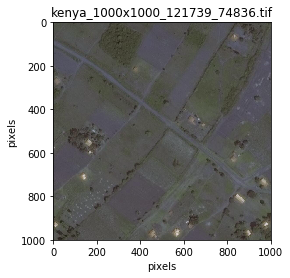

In [19]:
kenya_road_image = kenya_road_images[np.random.randint(len(kenya_road_images))].strip()
kenya_road_image = "kenya_1000x1000_121739_74836.tif"

kenya_path = os.path.join("/home/jkamalu/roadtype/kenya_road_images", kenya_road_image)
kenya_road_ds = show(kenya_path)
# kenya_road_image = "kenya_1000x1000_4023_316146.tif" -> 1 band ?

Path:  roadtype/peru_road_images/peru_1000x1000_523_388271.tif
Shape:  (1000, 1000, 3)


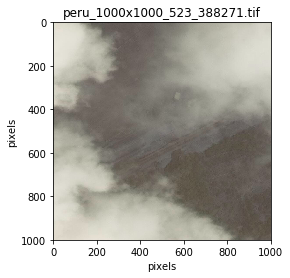

In [56]:
peru_road_image = peru_road_images[np.random.randint(len(peru_road_images))].strip()
# peru_road_image = "peru_1000x1000_64381_135109.tif"
peru_path = "roadtype/peru_road_images/" + peru_road_image
peru_road_ds = show(peru_path)